In [1]:
import sys
import os

In [2]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "...")))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), "..")))

# Tutorial 1: Reading partitioned data and loading a sample

Human mobility datasets are typically massive and are typically partitioned and stored in remote databases or buckets. Furthermore, spatiotemporal data can often have varying formats, coordinate projections, and imbalances in the amount of data for each user.

In this short script we demonstrate how to use Nomad to ingest data in different formats, both locally and remote. In this script we demonstrate the use of local "pure-python" methods for data ingestion, while in the next script we demonstrate the analogous pyspark implementations.

Let's examine the partition structure of the sample of data found in gc-sample-data, corresponding to the "Garden City" synthetic dataset. 

In [6]:
!tree gc-sample-data /F /A 

Folder PATH listing
Volume serial number is 000000B7 8A4A:8FD3
C:\USERS\FRANC\DOCUMENTS\NOTEBOOKS\DAPHME\EXAMPLES\GC-SAMPLE-DATA
+---date=2024-01-01
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet
|       
+---date=2024-01-02
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet
|       
+---date=2024-01-03
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet
|       
+---date=2024-01-04
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet
|       
+---date=2024-01-05
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet
|       
+---date=2024-01-06
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet
|       
+---date=2024-01-07
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet
|       
+---date=2024-01-08
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet
|       
+---date=2024-01-09
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet
|       
+---date=2024-01-10
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet
|       
+---date=2024-01-11
|       aad4a23f7a90441aa0f55f06e5e4313d-0.parquet


## Loading data from local files

In [17]:
from nomad import daphmeIO as loader
import matplotlib.pyplot as plt

Nomad's data loader combines convenient loader functions from ```Pandas``` and ```Pyarrow``` that parse through partitioned folder structures to return a pandas dataframe. 

In [10]:
df = loader.from_file('gc-sample-data/', format='parquet')
df

,uid,timestamp,latitude,longitude,date
0,wizardly_joliot,1704119340,38.321711,-36.667334,2024-01-01
1,wizardly_joliot,1704119700,38.321676,-36.667365,2024-01-01
0,wonderful_swirles,1704121560,38.321017,-36.667869,2024-01-01
0,youthful_galileo,1704098820,38.321625,-36.666612,2024-01-01
1,youthful_galileo,1704103140,38.321681,-36.666841,2024-01-01
...,...,...,...,...,...
1691,angry_spence,1705303380,38.320399,-36.667438,2024-01-15
1692,angry_spence,1705303740,38.320413,-36.667469,2024-01-15
1693,angry_spence,1705303980,38.320384,-36.667455,2024-01-15
1694,angry_spence,1705304340,38.320349,-36.667473,2024-01-15


<Axes: title={'center': 'Sample Trajectory for a random user on "2024-01-15"'}, xlabel='Longitude', ylabel='Latitude'>

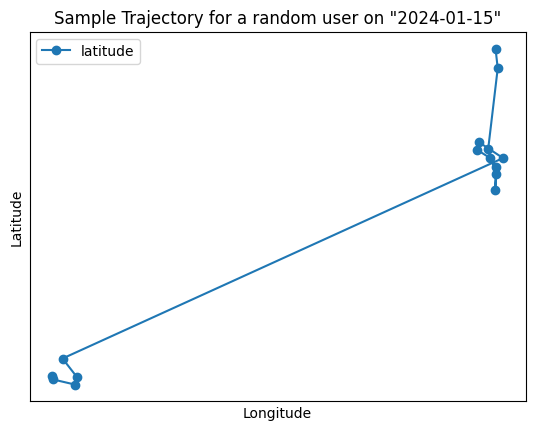

In [23]:
# Plot the trajectory of a single user in a day
user_traj = df.loc[(df.uid == "youthful_galileo")&(df.date=='2024-01-15')]

user_traj.plot('longitude',
               'latitude',
               marker='o',
               xlabel='Longitude',
               ylabel='Latitude',
               xticks=[],
               yticks=[],
               title= 'Sample Trajectory for a random user on "2024-01-15"')

In [17]:
# part_path = '../data/sample3/date=2024-01-07/aad4a23f7a90441aa0f55f06e5e4313d-0.parquet'
# part_path = "s3://phl-pings/gravy_clean/date=2019-11-01/part-00007-a7eb387d-1b0c-4aa7-b6a1-47023f1940bd.c000.snappy.parquet"
part_path = "s3://synthetic-raw-data/agents-*/sparse_trajectories.parquet/"

traj_cols =  {"user_id":"identifier",
              "x":"x",
              "y":"y",
              "datetime":"local_timestamp"}

### Get a sample of users

In [ ]:
u_sample = loader.sample_users("s3://synthetic-raw-data/agents-*/sparse_trajectories.parquet/", format='parquet', frac_users=0.2, user_id='identifier')

In [11]:
u_sample

32      95d1d4b8-c2f8-3de3-855f-1fb3f8b2f7d1
577     afde08d5-012c-3e88-ad8c-3a966ee5f730
415     5d7c5f71-e137-3e1a-890a-e79259a8851c
685     7e4c7c31-f344-434e-b0d0-f2ad922b01df
713     a24b62e2-84aa-3340-a61b-65979918a20e
                        ...                 
1533    76c7a082-fa60-3d52-a4be-10233b4ba0ef
1218    e6e00d07-02e1-3b18-87bc-a6aa8ebac5b9
492     225c9971-7a56-3847-a5af-05e4d3f5beba
1027    1a238312-7472-3c55-b451-c50825ef0063
792     fc1c2734-535d-3f84-a53a-2dfc614b66b9
Length: 308, dtype: object

### Load data for users in u_sample for 3 days

In [12]:
filepath = ['s3://phl-pings/gravy_clean/date=2019-11-01/',
            's3://phl-pings/gravy_clean/date=2019-11-02/',
            's3://phl-pings/gravy_clean/date=2019-11-03/',
            's3://phl-pings/gravy_clean/date=2019-11-04/',
            's3://phl-pings/gravy_clean/date=2019-11-05/',
            's3://phl-pings/gravy_clean/date=2019-11-06/']

data = loader.sample_from_file(part_path, users=u_sample, format='parquet', traj_cols=traj_cols, user_id = 'identifier')

In [13]:
data

,identifier,local_timestamp,mercator_coord,x,y,in_geo,date_hour,day_of_week,date
0,7f567d20-a527-3b75-b8d5-123415a52dcd,2019-11-01 08:51:10,b'\x12\x00\x00\x00\x01\x00\x00\x00\xc5\xc6\x14...,-8.382574e+06,4.856299e+06,False,2019-11-01 08,6,2019-11-01
1,7f567d20-a527-3b75-b8d5-123415a52dcd,2019-11-01 08:51:10,b'\x12\x00\x00\x00\x01\x00\x00\x00\xc5\xc6\x14...,-8.382574e+06,4.856299e+06,False,2019-11-01 08,6,2019-11-01
2,a7f7846d-4ca7-457b-9aba-7a95f47dcf86,2019-11-01 00:59:27,"b'\x12\x00\x00\x00\x01\x00\x00\x00\'>\xf7\xff""...",-8.337548e+06,4.868362e+06,False,2019-11-01 00,6,2019-11-01
3,a7f7846d-4ca7-457b-9aba-7a95f47dcf86,2019-11-01 03:47:42,"b'\x12\x00\x00\x00\x01\x00\x00\x00\'>\xf7\xff""...",-8.337548e+06,4.868362e+06,False,2019-11-01 03,6,2019-11-01
4,a7f7846d-4ca7-457b-9aba-7a95f47dcf86,2019-11-01 09:29:26,b'\x12\x00\x00\x00\x01\x00\x00\x00\xac\xd6\x95...,-8.313929e+06,4.902924e+06,False,2019-11-01 09,6,2019-11-01
...,...,...,...,...,...,...,...,...,...
15098,750d04af-8c86-3621-84f4-5f823ee22383,2019-11-01 03:43:41,"b'\x12\x00\x00\x00\x01\x00\x00\x00\xca@\xd9""\x...",-8.359505e+06,4.867844e+06,True,2019-11-01 03,6,2019-11-01
15099,750d04af-8c86-3621-84f4-5f823ee22383,2019-11-01 20:23:50,"b""\x12\x00\x00\x00\x01\x00\x00\x00R\x17\xf5'\x...",-8.369757e+06,4.854935e+06,True,2019-11-01 20,6,2019-11-01
15100,76c7a082-fa60-3d52-a4be-10233b4ba0ef,2019-11-01 05:00:43,b'\x12\x00\x00\x00\x01\x00\x00\x009\xc4!1\xe2\...,-8.358793e+06,4.868443e+06,True,2019-11-01 05,6,2019-11-01
15101,76c7a082-fa60-3d52-a4be-10233b4ba0ef,2019-11-01 23:59:08,b'\x12\x00\x00\x00\x01\x00\x00\x009\xc4!1\xe2\...,-8.358793e+06,4.868443e+06,True,2019-11-01 23,6,2019-11-01


In [14]:
data['timestamp'] = data[traj_cols['datetime']].astype(int) // 10**9

### Project coordinates to Web Mercator

In [ ]:
data = filters.to_projection(data, x='x', y='y')

### Compute the q-statistic for the users in this sample

In [ ]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, LongType, DoubleType


# user can pass latitude and longitude as kwargs, user can pass x and y, OR traj_cols (prioritizing latitude, longitude). 
def to_projection(df: pd.DataFrame,
                  latitude: str,
                  longitude: str,
                  from_crs: str = "EPSG:4326",
                  to_crs: str = "EPSG:3857",
                  spark_session: SparkSession = None):
    """
    Projects latitude and longitude columns from one CRS to another.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing latitude and longitude columns.
    latitude : str
        Name of the latitude column.
    longitude : str
        Name of the longitude column.
    from_crs : str, optional
        EPSG code for the original CRS (default is "EPSG:4326").
    to_crs : str, optional
        EPSG code for the target CRS (default is "EPSG:3857").

    Returns
    -------
    pd.DataFrame
        DataFrame with new 'x' and 'y' columns representing projected coordinates.
    """
    if spark_session:
        pass

    else:
        if latitude not in df.columns or longitude not in df.columns:
            raise ValueError(f"Latitude or longitude columns '{latitude}', '{longitude}' not found in DataFrame.")

        proj_cols = _to_projection(df[latitude],
                                   df[longitude],
                                   from_crs,
                                   to_crs)

        df['x'] = proj_cols['x']
        df['y'] = proj_cols['y']

    return df


def _to_projection(lat_col,
                   long_col,
                   from_crs: str,
                   to_crs: str):
    """
    Helper function to project latitude/longitude columns to a new CRS.
    """
    gdf = gpd.GeoSeries(gpd.points_from_xy(long_col, lat_col),
                        crs=from_crs)
    projected = gdf.to_crs(to_crs)
    output = pd.DataFrame({'x': projected.x, 'y': projected.y})

    return output


def filter_to_box(df: pd.DataFrame,
                  latitude: str,
                  longitude: str,
                  polygon: Polygon,
                  spark_session: SparkSession = None):
    '''
    Filters DataFrame to keep points within a specified polygon's bounds.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame with latitude and longitude columns.
    polygon : shapely.geometry.Polygon
        Polygon defining the area to retain points within.
    latitude : str
        Name of the latitude column.
    longitude : str
        Name of the longitude column.

    Returns
    -------
    pd.DataFrame
        Filtered DataFrame with points inside the polygon's bounds.
    '''
    if spark_session:
        pass

    else:
        if not isinstance(polygon, Polygon):
            raise TypeError("Polygon parameter must be a Shapely Polygon object.")

        if latitude not in df.columns or longitude not in df.columns:
            raise ValueError(f"Latitude or longitude columns '{latitude}', '{longitude}' not found in DataFrame.")

        min_x, min_y, max_x, max_y = polygon.bounds

        # TO DO: handle different column names and/or defaults as in daphmeIO. i.e. traj_cols as parameter

        return df[(df[longitude].between(min_y, max_y)) & (df[latitude].between(min_x, max_x))]


def _filter_to_box_spark(df: pd.DataFrame,
                         bounding_wkt: str,
                         spark: SparkSession,
                         longitude_col: str,
                         latitude_col: str,
                         id_col: str):
    """Filters a DataFrame based on whether geographical points
    (defined by longitude and latitude) fall within a specified geometry.

    Parameters
    ----------
    df : DataFrame
        The Spark DataFrame to be filtered. It should contain columns
        corresponding to longitude and latitude values, as well as an id column.

    bounding_wkt : str
        The Well-Known Text (WKT) string representing the bounding geometry
        within which points are tested for inclusion. The WKT should define
        a polygon in the EPSG:4326 coordinate reference system.

    spark : SparkSession
        The active SparkSession instance used to execute Spark operations.

    longitude_col : str, default "longitude"
        The name of the column in 'df' containing longitude values. Longitude
        values should be in the EPSG:4326 coordinate reference system.

    latitude_col : str, default "latitude"
        The name of the column in 'df' containing latitude values. Latitude
        values should be in the EPSG:4326 coordinate reference system.

    id_col : str, default "id"
        The name of the column in 'df' containing user IDs.

    Returns
    ----------
    DataFrame
        A new Spark DataFrame filtered to include only rows where the point
        (longitude, latitude) falls within the specified geometric boundary
        defined by 'bounding_wkt'. This DataFrame includes all original columns
        from 'df' and an additional column 'in_geo' that is true if the point
        falls within the specified geometric boundary and false otherwise.
    """

    df = df.withColumn("coordinate", F.expr(f"ST_MakePoint({longitude_col}, {latitude_col})"))
    df.createOrReplaceTempView("temp_df")

    query = f"""
        WITH temp_df AS (
            SELECT *,
                   ST_Contains(ST_GeomFromWKT('{bounding_wkt}'), coordinate) AS in_geo
            FROM temp_df
        ),

        UniqueIDs AS (
            SELECT DISTINCT {id_col} 
            FROM temp_df
            WHERE in_geo
        )

        SELECT t.*
        FROM temp_df t
        WHERE t.{id_col} IN (SELECT {id_col} FROM UniqueIDs)
        """

    return spark.sql(query)


def coarse_filter(df: pd.DataFrame):
    pass


def _filtered_users(df: pd.DataFrame,
                    k: int,
                    T0: str,
                    T1: str,
                    polygon: Polygon,
                    user_col: str,
                    timestamp_col: str,
                    latitude_col: str,
                    longitude_col: str) -> pd.DataFrame:
    """
    Subsets to users who have at least k distinct days with pings in the polygon 
    within the timeframe T0 to T1.

    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing user data with latitude, longitude, and timestamp.
    k : int
        Minimum number of distinct days with pings inside the polygon for the user to be retained.
    T0 : str
        Start of the timeframe (as a string, or datetime).
    T1 : str
        End of the timeframe (as a string, or datetime).
    polygon : Polygon
        The polygon to check whether pings are inside.
    user_col : str
        Name of the column containing user identifiers.
    timestamp_col : str
        Name of the column containing timestamps (as strings or datetime).
    latitude : str
        Name of the column containing latitude values.
    longitude : str
        Name of the column containing longitude values.

    Returns
    -------
    pd.Series
        A Series containing the user IDs for users who have at 
        least k distinct days with pings inside the polygon.
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])
    df_filtered = df[(df[timestamp_col] >= T0) & (df[timestamp_col] <= T1)]
    df_filtered = _in_geo(df_filtered, latitude_col, longitude_col, polygon)
    df_filtered['date'] = df_filtered[timestamp_col].dt.date

    filtered_users = (
        df_filtered[df_filtered['in_geo'] == 1]
        .groupby(user_col)['date']
        .nunique()
        .reset_index()
    )

    filtered_users = filtered_users[filtered_users['date'] >= k][user_col]

    return filtered_users


def _in_geo(df: pd.DataFrame,
            latitude_col: str,
            longitude_col: str,
            polygon: Polygon) -> pd.DataFrame:
    """
    Adds a new column to the DataFrame indicating whether points are 
    inside the polygon (1) or not (0).
    """

    def _point_in_polygon(lat, lon):
        point = Point(lat, lon)
        return 1 if polygon.contains(point) else 0

    df['in_geo'] = df.apply(lambda row: _point_in_polygon(row[latitude_col], row[longitude_col]), axis=1)

    return df


def q_filter(df: pd.DataFrame,
             qbar: float,
             user_col: str,
             timestamp_col: str):
    """
    Computes the q statistic for each user as the proportion of unique hours with pings 
    over the total observed hours (last hour - first hour) and filters users where q > qbar.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing user IDs and timestamps.
    user_col : str
        The name of the column containing user IDs.
    timestamp_col : str
        The name of the column containing timestamps.
    qbar : float
        The threshold q value; users with q > qbar will be retained.

    Returns
    -------
    pd.Series
        A Series containing the user IDs for users whose q_stat > qbar.
    """
    df[timestamp_col] = pd.to_datetime(df[timestamp_col])

    user_q_stats = df.groupby(user_col).apply(
        lambda group: _compute_q_stat(group, timestamp_col)
    ).reset_index(name='q_stat')

    # Filter users where q > qbar
    filtered_users = user_q_stats[user_q_stats['q_stat'] > qbar][user_col]

    return filtered_users

def q_stats(df: pd.DataFrame, user_id: str, timestamp: str):
    """
    Computes the q statistic for each user as the proportion of unique hours with pings 
    over the total observed hours (last hour - first hour).

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing user IDs and timestamps.
    user_id : str
        The name of the column containing user IDs.
    timestamp_col : str
        The name of the column containing timestamps.

    Returns
    -------
    pd.DataFrame
        A DataFrame containing each user and their respective q_stat.
    """
    datetime = pd.to_datetime(df[timestamp])

    q_stats = df.groupby(user_id).apply(
        lambda group: _compute_q_stat(group, datetime)
    ).reset_index(name='q_stat')

    return q_stats


def _compute_q_stat(user, datetime):
    date_hour = datetime.dt.to_period('h')
    unique_hours = date_hour.nunique()

    # Calculate total observed hours (difference between last and first hour)
    first_hour = date_hour.min()
    last_hour = date_hour.max()
    # maybe it should be + 1 hour
    total_hours = (last_hour - first_hour).total_seconds() / 3600

    # Compute q as the proportion of unique hours to total hours
    q_stat = unique_hours / total_hours if total_hours > 0 else 0
    if q_stat>1:
        pdb.set_trace()
    return q_stat

In [ ]:
q = q_stats(data, user_id= traj_cols['user_id'], timestamp= traj_cols['timestamp'])

In [ ]:
# Plotting the histogram

plt.figure(figsize=(4, 3))
plt.hist(q_stats['q_stat'], bins=20, edgecolor='black')
plt.xlabel('Q Statistic')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()